# 2. Predicitions

In this step, we take our 524 kb one-hot inputs from FlashZoi preparation and run them through the pretrained Borzoi model to predict CAGE signal in **skeletal muscle**. We:

1. Load our FlashZoi metadata (`flashzoi_meta.tsv`), which tells us where each `.npy` lives and its measured GTEx TPM.
2. Pull down Borzoi’s config/checkpoint so that we can ask it to return **all** output tracks (not just the central bin).
3.Find the CAGE skeletal-muscle track index list based on the FANTOM5 target list: https://github.com/johahi/borzoi-pytorch/blob/main/borzoi_pytorch/precomputed/targets.txt OR https://github.com/calico/borzoi/blob/main/examples/targets_gtex.txt
4. For each gene:
   - Load its one-hot array.
   - Run a forward pass.
   - Slice out that one skeletal-muscle track (length 16 352 bins).
   - Save both the full per-bin prediction and its mean.
5. Write out a combined `borzoi_preds_meta.tsv` so we can join predictions back to expression.

In [15]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from borzoi_pytorch import Borzoi
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from pathlib import Path

In [37]:
META_TSV   = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open/flashzoi_inputs/flashzoi_meta.tsv"
OUT_DIR    = "../data/output/dataset1/borzoi_preds"
CKPT = "johahi/borzoi-replicate-3"
DEVICE     = torch.device("cpu")
TARGETS_TXT= "../data/initial/targets_human.txt"     # CAGE/RNA track list
DTYPE      = torch.float32                                   # keep FP32

os.makedirs(OUT_DIR, exist_ok=True)

In [56]:
#!/usr/bin/env python3
"""
Run Borzoi on every gene listed in `META_TSV`, average the *muscle* tracks,
and save per-gene predictions.
"""

def collect_muscle_tracks(txt: Path) -> list[int]:
    """Return a sorted list of local track indices whose description contains 'muscle'."""
    df = pd.read_csv(txt, sep="\t", comment="#", header=0)
    df["local_index"] = np.arange(len(df))
    mask   = df["description"].str.contains(r"skeletal muscle", case=False, na=False)
    tracks = sorted(df.loc[mask, "local_index"].astype(int).tolist())
    if not tracks:
        raise RuntimeError("No tracks with the word 'muscle' found in targets_human.txt")
    print(f"→ using {len(tracks)} skeletal muscle tracks\n",
          df.loc[tracks[:5], ["local_index", "identifier", "description"]], "\n")
    return tracks

MUSCLE_TRACKS = collect_muscle_tracks(TARGETS_TXT)

print("Loading Borzoi checkpoint:", CKPT)
model = Borzoi.from_pretrained(
    CKPT,
    torch_dtype=DTYPE,
    low_cpu_mem_usage=False          # loading real weights, not meta tensors
)
model.config.return_center_bins_only = False   # 524 288-bp output, not center bin
model = model.to_empty(device=DEVICE).eval()

OUT_DIR.mkdir(parents=True, exist_ok=True)
meta_df   = pd.read_csv(META_TSV, sep="\t")
results   : list[dict] = []

for i, row in meta_df.iterrows():
    gene   = row["gene"]
    onehot = np.load(row["onehot_path"]).astype(np.float32)   # shape (4, 524 288)
    x      = torch.from_numpy(onehot).unsqueeze(0).to(DEVICE) # shape (1, 4, 524 288)

    with torch.no_grad():
        y = model(x)
        y = y["human"] if isinstance(y, dict) else y          # (1, n_tracks, n_bins)
        if y.dim() != 3:
            raise RuntimeError(f"{gene}: unexpected output shape {tuple(y.shape)}")
        # mean across all muscle-related tracks
        bins = y[0, MUSCLE_TRACKS].mean(0).cpu().numpy()      # (n_bins,)

    gdir = OUT_DIR / gene
    gdir.mkdir(exist_ok=True)
    np.save(gdir / f"{gene}_borzoi_pred.npy", bins)
    mean_ref = float(bins.mean())
    np.save(gdir / "mean_ref.npy", mean_ref)

    results.append({
        "gene":        gene,
        "expr_value":  row["expr_value"],
        "expr_rank":   row["expr_rank"],
        "overlaps2kb": row["overlaps2kb"],
        "pred_npy":    str(gdir / f"{gene}_borzoi_pred.npy"),
        "mean_ref":    mean_ref,
    })
    print(f"[{i+1}/{len(meta_df)}] {gene:15s}  mean_ref = {mean_ref:8.4f}")

pd.DataFrame(results).to_csv(OUT_DIR / "borzoi_preds_meta.tsv", sep="\t", index=False)
print("All predictions complete – metadata written to",
      OUT_DIR / "borzoi_preds_meta.tsv")

→ using 66 muscle tracks (example rows shown below)
      local_index  identifier                            description
32            32  CNhs10629+     CAGE:skeletal muscle, adult, pool1
33            33  CNhs10629-     CAGE:skeletal muscle, adult, pool1
198          198  CNhs11964+  CAGE:Skeletal Muscle Satellite Cells,
199          199  CNhs11964-  CAGE:Skeletal Muscle Satellite Cells,
274          274  CNhs12053+            CAGE:Skeletal Muscle Cells, 

Loading Borzoi checkpoint: johahi/borzoi-replicate-2


/Users/markus/seq2expr-variance/.venv/lib/python3.12/site-packages/borzoi_pytorch/pytorch_borzoi_model.py:282: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[1/15] ENSG00000077984  mean_ref =      nan
[2/15] ENSG00000197122  mean_ref =      nan
[3/15] ENSG00000101333  mean_ref =      nan
[4/15] ENSG00000020256  mean_ref =      nan
[5/15] ENSG00000170191  mean_ref =      nan
[6/15] ENSG00000149639  mean_ref =      nan
[7/15] ENSG00000088827  mean_ref =      nan
[8/15] ENSG00000124217  mean_ref =      nan
[9/15] ENSG00000089123  mean_ref =      nan
[10/15] ENSG00000171940  mean_ref =      nan
[11/15] ENSG00000089057  mean_ref =      nan
[12/15] ENSG00000101052  mean_ref =      nan
[13/15] ENSG00000131061  mean_ref =      nan
[14/15] ENSG00000158445  mean_ref =      nan
[15/15] ENSG00000196839  mean_ref =      nan

✓ All predictions complete – metadata written to ../data/output/dataset1/borzoi_preds/borzoi_preds_meta.tsv


# 2. Predict Variant ΔS and Compute Genetic Variance

For each common gnomAD SNP in our ±262 kb windows, we:

1. Load its reference one-hot and the precomputed **mean_ref** prediction.
2. Mutate the one-hot at the SNP position (zero out the ref base, set the alt base).
3. Batch up a handful of these ALT one-hots and run them through Borzoi.
4. Compute Δ = (mean signal on ALT) – **mean_ref**, then
   \ [
      $\mathrm{var}_i \;=\; \Delta^2 \times 2\,\mathrm{AF}(1-\mathrm{AF})$
   \]
   which is the per-variant contribution to expected genetic variance.
5. Write `delta` and `var_i` back into each gene’s `*_variants.tsv`.

In [50]:
"""
For every gnomAD SNP in ±262 kb of the TSS, run Borzoi on the ALT-allele
sequence, subtract the reference signal, and write delta + var_i back
into each *_variants.tsv
"""

VARIANTS_DIR = "../data/intermediate/dataset1/flashzoi_inputs/variants"
ONEHOT_DIR   = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open/flashzoi_inputs"
PRED_DIR     = "../data/output/dataset1/borzoi_preds"

DEVICE = torch.device("mps")
model  = Borzoi.from_pretrained(
            "johahi/borzoi-replicate-",
            torch_dtype=torch.float32,
            low_cpu_mem_usage=True
        ).to_empty(device=DEVICE).eval()

BATCH_SIZE = 6
BIN_SIZE   = 128
CENTER_BIN = 524_288 // BIN_SIZE // 2          # 4 096
WIN        = slice(CENTER_BIN-16, CENTER_BIN+16)
BASE2ROW   = {b: i for i, b in enumerate("ACGT")}

2.1 Iterate genes & predict deltas

In [52]:
genes = sorted([g for g in os.listdir(VARIANTS_DIR)
                if os.path.isfile(os.path.join(VARIANTS_DIR, g, f"{g}_variants.tsv"))])

for gene in genes:
    # lodaing variants table
    var_tsv = os.path.join(VARIANTS_DIR, gene, f"{gene}_variants.tsv")
    snps = pd.read_csv(var_tsv, sep="\t")
    if snps.empty:
        print(f"▶ {gene}  (no variants)"); continue

    print(f"▶ {gene}")
    # loading reference inputs & ref_mean
    ref_onehot = np.load(os.path.join(ONEHOT_DIR, f"{gene}.npy")).astype(np.float32)
    ref_mean   = float(np.load(os.path.join(PRED_DIR, gene, "mean_ref.npy")))

    deltas, batch = [], []
    # tqdm over DataFrame rows gives a slick progress bar
    for idx, v in tqdm(snps.iterrows(), total=len(snps), desc="   SNPs", leave=False):
        # make ALT one-hot
        alt_oh = ref_onehot.copy()
        col = int(v.POS0)
        alt_oh[:, col] = 0.0
        if v.ALT not in BASE2ROW:                # skip non-ACGT alleles
            deltas.append(np.nan); continue
        alt_oh[BASE2ROW[v.ALT], col] = 1.0
        batch.append(torch.from_numpy(alt_oh).unsqueeze(0))

        # run when batch full or last SNP, when batch is full or at last SNP, run inference
        if len(batch) == BATCH_SIZE or idx == len(snps)-1:
            xb = torch.cat(batch).to(DEVICE)
            with torch.no_grad():
                y = model(xb)
                y = y["human"] if isinstance(y, dict) else y
                sig = (y[:, 1, WIN] if y.dim()==3 else y[:, WIN]).mean(dim=1)
            #Δ = ALT – ref, then append
            deltas.extend((sig.cpu().numpy() - ref_mean))
            batch.clear()

    # write back results
    snps["delta"] = deltas
    snps["AF_float"] = pd.to_numeric(snps["AF"], errors="coerce")
    snps["var_i"] = (snps["delta"]**2) * (2 * snps["AF_float"] * (1 - snps["AF_float"]))
    snps.to_csv(var_tsv, sep="\t", index=False)
    print(f"   → wrote delta + var_i ({len(snps)} rows)")

print("All genes processed")

▶ ENSG00000020256


   SNPs:   0%|          | 0/17355 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 16.70 GB, other allocations: 2.80 MB, max allowed: 18.13 GB). Tried to allocate 6.00 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## 3. Inspect data

## 3.1 Reference vs Expression

In [11]:
PRED_META = "../data/output/dataset1/borzoi_preds/borzoi_preds_meta.tsv"
VAR_DIR   = "../data/intermediate/dataset1/flashzoi_inputs/variants"

/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_14488/243157249.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = pearsonr(preds["expr_value"], preds["mean_ref"])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_14488/243157249.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_r, spearman_p = spearmanr(preds["expr_value"], preds["mean_ref"])


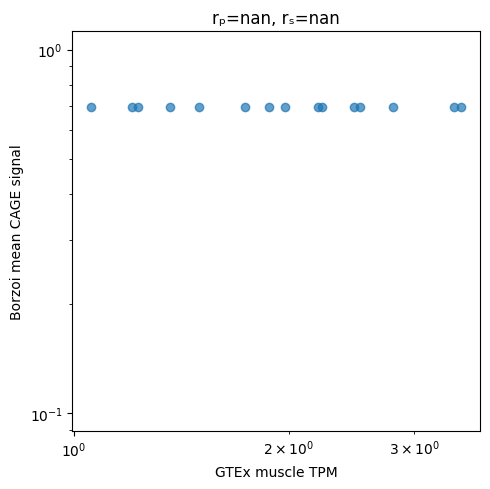

In [13]:
preds = pd.read_csv(PRED_META, sep="\t")
plt.figure(figsize=(5,5))
plt.scatter(preds["expr_value"], preds["mean_ref"], alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GTEx muscle TPM")
plt.ylabel("Borzoi mean CAGE signal")
pearson_r, pearson_p = pearsonr(preds["expr_value"], preds["mean_ref"])
spearman_r, spearman_p = spearmanr(preds["expr_value"], preds["mean_ref"])
plt.title(f"rₚ={pearson_r:.2f}, rₛ={spearman_r:.2f}")
plt.tight_layout()
plt.show()

## 3.2 Δ distribution across all variants

In [16]:
# gather every 'delta' column
all_deltas = []
for tsv in glob.glob(os.path.join(VAR_DIR, "*", "*_variants.tsv")):
    df = pd.read_csv(tsv, sep="\t")
    all_deltas.append(df["delta"].dropna().astype(float))
all_deltas = pd.concat(all_deltas, ignore_index=True)

plt.figure(figsize=(5,4))
plt.hist(all_deltas, bins=100)
plt.xlabel("Δ (Borzoi ALT − REF)")
plt.ylabel("Count")
plt.title("Distribution of predicted Δ across all variants")
plt.tight_layout()
plt.show()

KeyError: 'delta'

## 3.3 per‐gene expected genetic variance

In [ ]:
gene_var = {}
for tsv in glob.glob(os.path.join(VAR_DIR, "*", "*_variants.tsv")):
    gene = os.path.basename(os.path.dirname(tsv))
    df = pd.read_csv(tsv, sep="\t")
    gene_var[gene] = df["var_i"].sum()

var_df = pd.DataFrame.from_dict(gene_var, orient="index", columns=["exp_genetic_var"])
var_df.index.name = "gene"
var_df = var_df.reset_index()

# merge with expression
merged = preds.merge(var_df, on="gene")
merged.head()

## 3.4 scatter expected genetic variance vs. expression

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(merged["expr_value"], merged["exp_genetic_var"], alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GTEx muscle TPM")
plt.ylabel("Expected genetic variance ∑var_i")
plt.title("Genetic variance vs expression")
plt.tight_layout()
plt.show()

## 3.5 Inspecting one variant file

In [17]:
example = glob.glob(os.path.join(VAR_DIR, "*", "*_variants.tsv"))[0]
print("Example file:", example)
pd.read_csv(example, sep="\t").head()

Example file: ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000131061/ENSG00000131061_variants.tsv


,CHROM,POS,POS0,REF,ALT,AF
0,chr20,33471042,1190,A,G,0.001021
1,chr20,33471186,1334,T,C,0.001342
2,chr20,33471221,1369,C,A,0.010552
3,chr20,33471221,1369,C,CA,0.015539
4,chr20,33471221,1369,CA,C,0.003863
